# AC109 Project EDA: Predicting the returns on Cryptocurrencies

by Ali Dastjerdi, Angelina Massa, Sachin Mathur & Nate Stein

### Project Goal

To predict the price return of one cryptocurrency based on the returns of other cryptocurrencies; market data, including equity indices and other benchmarks; and cryptocurrency news.

### Work Load

1. Creating basic data pipelines and evaluating different model possibilities.
2. Using NLP techniques to convert unstructured news data concerning cryptocurrencies into features that can be fed into model.

### Cryptocurrency Scope

We focus on cryptocurrencies that have data going back to 2015 or earlier so we have more data points: btc, ltc, xrp, xlm, eth.

#### Earliest date data available
For top 10 cryptocurrencies in terms of market-cap, the following dates are the earliest dates closing price data is available:

    btc	4/28/2013
    ltc	4/28/2013
    xrp	8/4/2013
    xlm	8/5/2014
    eth	8/7/2015
    neo	9/9/2016
    miota	6/13/2017
    eos	7/1/2017
    bch	7/23/2017
    ada	10/1/2017

In [1]:
import crypto_utils as crypu
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from crypto_utils import fmt_date, print_update

In [43]:
# Custom output options.

np.set_printoptions(precision=3, suppress=True)
pd.set_option('display.precision', 3)
sns.set_style('white')
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.05
%matplotlib inline

# Flag for whether to (re)save figures into plots folder.
SAVE_FIGS = True

# Other global params.
# Used when we just want to include basis sense of time on x-axis 
# without crowding due to many x-ticks.
XTICKS_SIMPLE = [pd.to_datetime('1/1/2016'),
                 pd.to_datetime('1/1/2017'),
                 pd.to_datetime('1/1/2018')]

# EDA

### Basic Data Features

The code for most of the preprocessing is in the `crypto_utils` module.

#### Rolling Returns
Here we create two time series containing the daily rolling returns for a subset of cryptocurrencies and other assets:  (i) raw daily returns and (ii) daily returns centered and scaled to unit variance with respect to each cryptocurrency.

For example, the value for `btc` on 2015-08-09 in the raw DataFrame will be equal to:

$$\frac{\text{btc}_t}{\text{btc}_{t-1}}-1 = \frac{265.08}{261.00}-1=1.56\%$$

where $\text{btc}_t$ is the closing price of `btc` on 2015-08-09 and $\text{btc}_{t-1}$ is the closing price of `btc` on the previous day, 2015-08-08.

For non-cryptocurrency assets, the rolling return is calculated as the change in price between *available prices* since they typically do not trade on the weekends. To show the difference, let's assume a hypothetical date ($t$) of March 12, 2018 (a Monday). For cryptocurrencies, $t-1$ = March 11, 2018 (a Sunday), while for most non-cryptocurrency assets $t-1$ = March 9, 2018 (the preceding Friday).

In [3]:
# Load rolling returns time series.

ASSET_SCOPE = ['btc', 'ltc', 'xrp', 'xlm', 'eth', 'SP500']
tdelta = 1  # 1 day
analysis_end_dt = pd.to_datetime('3/31/2018')
df_raw = crypu.load_returns_matrix (ASSET_SCOPE, 
                                    end_date=analysis_end_dt, 
                                    xdays=tdelta, center=False, 
                                    scale=False)
df_std = crypu.load_returns_matrix (ASSET_SCOPE, 
                                    end_date=analysis_end_dt, 
                                    xdays=tdelta, center=True, scale=True)

In [4]:
# No reason start dates should be different for raw and standardized 
# DataFrames.
analysis_start_dt = pd.to_datetime(df_raw.index.values.min())
assert analysis_start_dt == df_std.index.values.min()
assert analysis_end_dt == df_std.index.values.max()

analysis_daycount = (analysis_end_dt - analysis_start_dt).days

print('Rolling returns time period:')
print('\tStart date: {}'.format(fmt_date(analysis_start_dt)))
print('\tEnd date: {}'.format(fmt_date(df_raw.index.values.max())))
print('\tObservations: {}'.format(df_raw.shape[0]))
print('\nRaw DataFrame:')
display(df_raw.head())
print('\nStandardized DataFrame:')
display(df_std.head())

Rolling returns time period:
	Start date: 08/08/2015
	End date: 03/31/2018
	Observations: 967

Raw DataFrame:


,btc,ltc,xrp,xlm,eth,SP500
2015-08-08,-0.066,-0.086,0.040,-0.005,-0.728,-2.875e-03
2015-08-09,0.016,0.013,0.039,-0.031,-0.068,-2.875e-03
2015-08-10,-0.002,0.013,-0.007,0.052,0.009,1.281e-02
2015-08-11,0.022,0.053,-0.018,-0.028,0.510,-9.557e-03
2015-08-12,-0.015,-0.041,-0.037,-0.008,0.140,9.501e-04



Standardized DataFrame:


,btc,ltc,xrp,xlm,eth,SP500
2015-08-08,-1.707,-1.426,0.326,-0.140,-9.351,-0.377
2015-08-09,0.277,0.121,0.320,-0.386,-0.974,-0.377
2015-08-10,-0.157,0.118,-0.148,0.416,0.011,1.458
2015-08-11,0.440,0.752,-0.266,-0.357,6.373,-1.159
2015-08-12,-0.460,-0.725,-0.461,-0.161,1.673,0.070


### Analysis of Unstandardized Daily Price Return Data

First we take a look at what the raw daily price return data looks like, i.e., the rolling daily returns that are not centered/scaled by cryptocurrency.

In [5]:
print('Price return statistics without centering/scaling:')
print('Mean returns:')
display(df_raw.mean(axis=0))
print('Standard deviation of returns:')
display(df_raw.std(axis=0))
print('Cumulative return:')
display((df_raw + 1).prod(axis=0))
print('Correlation:')
df_raw.corr()

Price return statistics without centering/scaling:
Mean returns:


btc      4.186e-03
ltc      5.301e-03
xrp      7.868e-03
xlm      8.962e-03
eth      8.431e-03
SP500    3.489e-04
dtype: float64

Standard deviation of returns:


btc      0.041
ltc      0.064
xrp      0.098
xlm      0.103
eth      0.079
SP500    0.009
dtype: float64

Cumulative return:


btc       24.943
ltc       27.698
xrp       62.850
xlm       85.024
eth      143.126
SP500      1.352
dtype: float64

Correlation:


,btc,ltc,xrp,xlm,eth,SP500
btc,1.000,0.512,0.187,0.259,0.299,0.058
ltc,0.512,1.000,0.255,0.281,0.273,0.053
xrp,0.187,0.255,1.000,0.473,0.119,0.020
xlm,0.259,0.281,0.473,1.000,0.167,0.031
eth,0.299,0.273,0.119,0.167,1.000,0.051
SP500,0.058,0.053,0.020,0.031,0.051,1.000


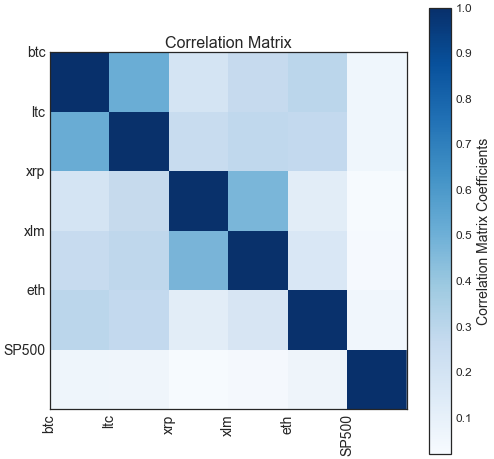

In [6]:
# Correlation matrix graph.

corr = np.corrcoef(df_raw.values.T)
plt.figure(figsize=(8, 8))
plt.imshow(corr, cmap='Blues', interpolation='none')
cb = plt.colorbar()
cb.set_label('Correlation Matrix Coefficients')
plt.title('Correlation Matrix', fontsize=16)

# Shift axes ticks b/c they defualt to center of squares.
ticks = np.arange(-0.5, len(ASSET_SCOPE), 1)
tick_labels = np.arange(1, len(ASSET_SCOPE), 1)
plt.xticks(ticks, ASSET_SCOPE, rotation=90, size=14)
plt.yticks(ticks, ASSET_SCOPE, size=14)
if SAVE_FIGS:
    plt.savefig('plots/corr.png')

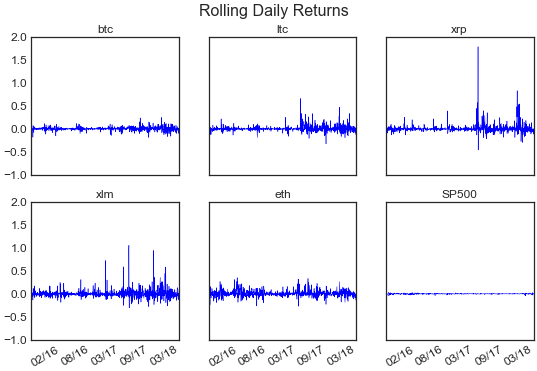

In [7]:
# Graph returns.

LW = 0.5  # line width
TS = 12  # subplot title size

# Number of rows and columns we'll need for all subplots.
INCHES_PER_ROW, INCHES_PER_COL = 3, 3
ax_rows, ax_cols = 2, 3
figsize = (ax_cols*INCHES_PER_COL, ax_rows*INCHES_PER_ROW)

# Create xticks so we have only 5 ticks.
desired_ticks = 5
days_per_tick = int(analysis_daycount/desired_ticks)
xticks = [analysis_start_dt + datetime.timedelta(days=x_*days_per_tick) for 
          x_ in range(1, desired_ticks+1)]

fig1, ax1 = plt.subplots(ax_rows, ax_cols, figsize=figsize,
                         sharex=True, sharey=True)
XAXIS_DATE_FORMAT = mdates.DateFormatter('%m/%y')
row, col = 0, 0

for asset in ASSET_SCOPE:
    ax1[row, col].plot(df_raw[asset], linewidth=LW)
    ax1[row, col].set_title(asset, size=TS)
    ax1[row, col].set_xticks(xticks)
    ax1[row, col].xaxis.set_major_formatter(XAXIS_DATE_FORMAT)
    
    # Increment axis index.
    if ((col + 1)%ax_cols)==0:
        # Move to next row since we're at last column.
        col = 0
        row += 1
    else:
        col += 1

fig1.autofmt_xdate()  #  so dates are rotated nicely on x-axis
fig1.suptitle('Rolling Daily Returns', size=16)
if SAVE_FIGS:
    fig1.savefig('plots/daily_rolling_all.png')

### Histograms of Unstandardized Cryptocurrency Returns

In [8]:
# Main histogram plotter.

HIST_BINS = 20
HIST_NORMED = False

def plot_hist(asset, bins=HIST_BINS, normed=HIST_NORMED, savefig=True):
    """Plot histogram where y-axis is p(x) and x is data for the given bin."""
    data = df_raw[asset].values
    plt.hist(data, bins=bins, normed=normed, align='mid',
             weights=np.ones(len(data)) / len(data))
    plt.title(asset)
    plt.xlabel('Unstandardized rolling return')
    plt.ylabel('Frequency')
    if savefig:
        plt.savefig('plots/hist_{}'.format(asset))
    plt.show()

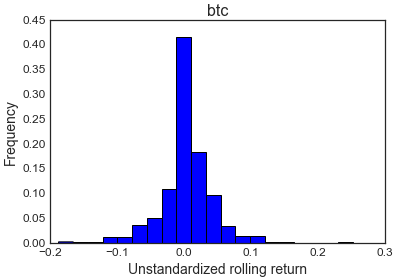

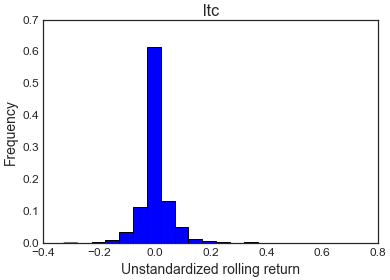

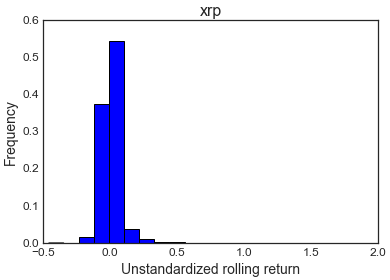

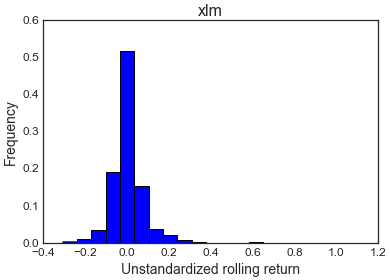

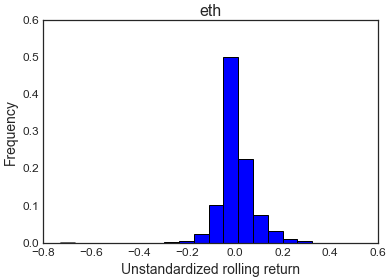

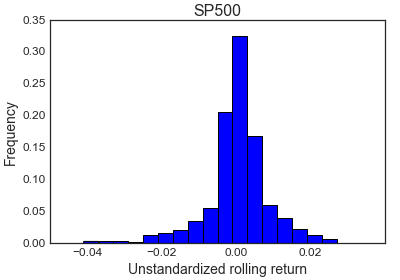

In [9]:
for asset in ASSET_SCOPE:
    plot_hist(asset, savefig=SAVE_FIGS)

### Histograms of (Return = Positive)

*Still using unstandardized returns. If return > 0.01, True; else, False.

# Prepare model data

#### Definition of rolling returns

We aim to One cryptocurrency's return will be the $Y$ value while the other currencies' returns will be the $X$.

In below example, `btc` is the cryptocurrency whose price return we try to predict. Therefore, one example of row in our training data would contain:
- Index: 3/30/2018
- $Y$: `btc`'s percentage change in `close` price from 3/29/2018 -> 3/30/2018.
- $X$: The other cryptocurrencies' percentage change in `close` price from 3/28/2018 -> 3/29/2018.

i.e., we want to use the rolling returns from the other cryptocurrencies on 3/29/2018 to predict the return of `btc` on the next day (3/30/2018).

For example, the price return for `eth` on original frame at 10/3/2017 was equal to $-0.329$. After shifting the returns forward one day in the following code, the price return for `eth` on 10/3/2017 becomes $-0.316$, the value for 10/2/2017 in the previous DF. 

In [10]:
y_asset = 'btc'  # crypto whose return we want to predict
x_assets = [c for c in df_std.columns if c != y_asset]
df_model = df_std.copy()
df_model[x_assets] = df_model[x_assets].shift(periods=1)
df_model.dropna(axis=0, how='any', inplace=True)
df_model.head()

,btc,ltc,xrp,xlm,eth,SP500
2015-08-09,0.277,-1.426,0.326,-0.140,-9.351,-0.377
2015-08-10,-0.157,0.121,0.320,-0.386,-0.974,-0.377
2015-08-11,0.440,0.118,-0.148,0.416,0.011,1.458
2015-08-12,-0.460,0.752,-0.266,-0.357,6.373,-1.159
2015-08-13,-0.310,-0.725,-0.461,-0.161,1.673,0.070


In [11]:
def display_df_subset(df, start, end):
    df = df[(df.index >= start) & (df.index <= end)]
    display(df)
    
def display_df_as_feat_matrix(df, start, end, ycol):
    df = df[(df.index >= start) & (df.index <= end)]
    renaming = {ycol: 'Y'}
    x_i = 0
    for c in df.columns:
        if c != ycol:
            renaming[c] = 'x_{}'.format(x_i)
            x_i += 1
    df = df.rename(columns=renaming)
    display(df)

In [12]:
display_df_subset(df_model, 
                  start=pd.to_datetime('12/26/2017'),
                  end=pd.to_datetime('1/5/2018'))

,btc,ltc,xrp,xlm,eth,SP500
2017-12-26,3.471,-0.231,0.706,0.089,1.204,-0.094
2017-12-27,-0.493,0.670,0.559,-0.194,0.026,-0.165
2017-12-28,-1.981,-0.869,1.725,0.051,-0.288,0.052
2017-12-29,-0.019,-1.366,0.139,-0.329,-0.537,0.174
2017-12-30,-2.911,-0.362,5.499,4.252,0.178,-0.647
2017-12-31,2.146,-1.781,-0.312,-0.080,-0.719,-0.647
2018-01-01,-0.953,0.859,0.582,1.046,0.592,-0.647
2018-01-02,2.243,-0.291,0.320,3.138,0.160,-0.647
2018-01-03,0.252,1.744,0.305,1.636,1.730,0.931
2018-01-04,0.532,-0.716,2.518,5.640,1.017,0.708


In [13]:
display_df_as_feat_matrix(df_model, 
                          start=pd.to_datetime('12/26/2017'),
                          end=pd.to_datetime('1/5/2018'),
                          ycol=y_asset)

,Y,x_0,x_1,x_2,x_3,x_4
2017-12-26,3.471,-0.231,0.706,0.089,1.204,-0.094
2017-12-27,-0.493,0.670,0.559,-0.194,0.026,-0.165
2017-12-28,-1.981,-0.869,1.725,0.051,-0.288,0.052
2017-12-29,-0.019,-1.366,0.139,-0.329,-0.537,0.174
2017-12-30,-2.911,-0.362,5.499,4.252,0.178,-0.647
2017-12-31,2.146,-1.781,-0.312,-0.080,-0.719,-0.647
2018-01-01,-0.953,0.859,0.582,1.046,0.592,-0.647
2018-01-02,2.243,-0.291,0.320,3.138,0.160,-0.647
2018-01-03,0.252,1.744,0.305,1.636,1.730,0.931
2018-01-04,0.532,-0.716,2.518,5.640,1.017,0.708


### Illustrating Changes in Return Characteristics

In [29]:
N_WINDOW = 30  # number of days to use in rolling window
CRYPTO = 'btc'

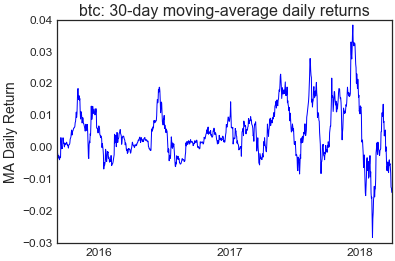

In [46]:
# Change in rolling mean over time.

title = '{0}: {1}-day moving-average daily returns'.format(CRYPTO, N_WINDOW)
savepath = 'plots/ma_returns_mean_{}'.format(CRYPTO)
plt.plot(df_raw[CRYPTO].rolling(window=N_WINDOW).mean())
plt.xticks(XTICKS_SIMPLE)
plt.title(title)
plt.ylabel('MA Daily Return');
if SAVE_FIGS:
    plt.savefig(savepath)

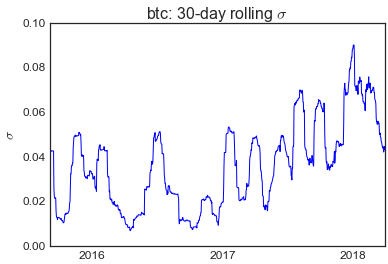

In [47]:
# Change in rolling standard deviation over time.

title = '{0}: {1}-day rolling $\sigma$'.format(CRYPTO, N_WINDOW)
savepath = 'plots/ma_returns_std_{}'.format(CRYPTO)
plt.plot(df_raw[CRYPTO].rolling(window=N_WINDOW).std())
plt.xticks(XTICKS_SIMPLE)
plt.title(title)
plt.ylabel('$\sigma$');
if SAVE_FIGS:
    plt.savefig(savepath)